In [108]:
import pandas as pd
import networkx as nx
from os import path
import requests
import re
import os
from bs4 import BeautifulSoup
import pickle
import bz2file as bz2
from urllib.request import urlopen
from urllib.parse import quote
import statistics as stats
import pickle
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt
import community as community_louvain
from collections import Counter
from wordcloud import WordCloud
from fa2_modified import ForceAtlas2
import matplotlib.colors as mcolors
import math
import networkx as nx
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
full_ml_dataset = False

In [63]:
def get_base_path():
    if full_ml_dataset:
        return "../data/ml/full"
    return "../data/ml/small"

In [64]:
def save(title, data):
    with bz2.BZ2File(f"{path.join(get_base_path(), title)}.pbz2", "w") as f:
        pickle.dump(data, f)

In [65]:
def load(title):
    with bz2.BZ2File(f"{path.join(get_base_path(), title)}.pbz2", "r") as f:
        return pickle.load(f)

In [66]:
def get_csv(name):
    return pd.read_csv(path.join(get_base_path(), name))

In [67]:
ratings = get_csv("ratings.csv")
movies = get_csv("movies.csv")
tags = get_csv("tags.csv")
links = get_csv("links.csv")

In [68]:
G = nx.Graph()
user_nodes = ratings['userId'].unique()
# Normalize - max rating is 10
ratings['rating'] = ratings['rating']/10
movie_nodes = ratings['movieId'].unique()

print(ratings.head())


G.add_nodes_from(movie_nodes, bipartite=0)
G.add_nodes_from(user_nodes, bipartite=1)
edges = ratings[['userId', 'movieId', 'rating']].values
G.add_weighted_edges_from(edges)

   userId  movieId  rating  timestamp
0       1        1     0.4  964982703
1       1        3     0.4  964981247
2       1        6     0.4  964982224
3       1       47     0.5  964983815
4       1       50     0.5  964982931


In [69]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 9811
Number of edges: 100403


In [70]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=False)

In [71]:
partition = community_louvain.best_partition(G)

partition_counts = Counter(partition.values())
most_common_partitions = partition_counts.most_common(10)

common_partitions_ids = set(community[0] for community in most_common_partitions)

colors = list(mcolors.TABLEAU_COLORS.keys())
partitions_colors = {partition_id: colors[i % len(colors)] for i, partition_id in enumerate(common_partitions_ids)}

node_colors = []
for node in G.nodes():
    community_id = partition[node]
    if community_id in partitions_colors:
        node_colors.append(partitions_colors[community_id])
    else:
        node_colors.append('lightgray')

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

KeyboardInterrupt: 

In [ ]:
modularity = community_louvain.modularity(partition, G)
print(f"Louvain Modularity: {modularity}")

Louvain Modularity: 0.25255369018571705


In [ ]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.05)
plt.axis('off')
plt.title("Network Visualization with Force Atlas Algorithm")
plt.show()

In [72]:
movies['genre_list'] = movies['genres'].apply(lambda x: x.split('|'))

movie_genres = movies[['movieId', 'genre_list']].set_index('movieId').to_dict()['genre_list']

In [73]:
movies['primary_genre'] = movies['genre_list'].apply(lambda x: x[0]) 

movie_to_genre = movies[['movieId', 'primary_genre']].set_index('movieId').to_dict()['primary_genre']

print(movie_to_genre)

{1: 'Adventure', 2: 'Adventure', 3: 'Comedy', 4: 'Comedy', 5: 'Comedy', 6: 'Action', 7: 'Comedy', 8: 'Adventure', 9: 'Action', 10: 'Action', 11: 'Comedy', 12: 'Comedy', 13: 'Adventure', 14: 'Drama', 15: 'Action', 16: 'Crime', 17: 'Drama', 18: 'Comedy', 19: 'Comedy', 20: 'Action', 21: 'Comedy', 22: 'Crime', 23: 'Action', 24: 'Drama', 25: 'Drama', 26: 'Drama', 27: 'Children', 28: 'Drama', 29: 'Adventure', 30: 'Crime', 31: 'Drama', 32: 'Mystery', 34: 'Children', 36: 'Crime', 38: 'Children', 39: 'Comedy', 40: 'Drama', 41: 'Drama', 42: 'Action', 43: 'Drama', 44: 'Action', 45: 'Comedy', 46: 'Drama', 47: 'Mystery', 48: 'Animation', 49: 'Drama', 50: 'Crime', 52: 'Comedy', 53: 'Adventure', 54: 'Children', 55: 'Drama', 57: 'Drama', 58: 'Comedy', 60: 'Adventure', 61: 'Drama', 62: 'Drama', 63: 'Comedy', 64: 'Comedy', 65: 'Comedy', 66: 'Action', 68: 'Comedy', 69: 'Comedy', 70: 'Action', 71: 'Action', 72: 'Comedy', 73: 'Drama', 74: 'Drama', 75: 'Comedy', 76: 'Action', 77: 'Documentary', 78: 'Action'

In [74]:
for node in G.nodes():
    if node in movie_to_genre:
        G.nodes[node]['community'] = movie_to_genre[node]
    else:
        G.nodes[node]['community'] = None 


In [75]:
genre_partition = {}
for node, data in G.nodes(data=True):
    community = data.get('community')
    if community:
        genre_partition.setdefault(community, []).append(node)

genre_communities = [set(nodes) for nodes in genre_partition.values()]

In [76]:
M = 0
L = G.number_of_edges()

for nodes in genre_communities:
    Lc = G.subgraph(nodes).number_of_edges()
    Kc = sum([x for _, x in G.subgraph(nodes).degree(nodes)])
    M += ((Lc/L)-((Kc/(2*L))**2))

print(f"Genre community modularity: {M}")

Genre community modularity: 0.15997045863914677


In [77]:
def get_user_rating_for_movie(user_id, movie_id):
    return ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movie_id)]['rating'].values[0]

In [78]:
def get_user_movies(user_id):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    return user_movies

In [79]:
def get_movie_title_from_id(movie_id):
    return movies[movies['movieId'] == movie_id]['title'].values[0]

In [80]:
def get_movies_for_genre(genre):
    genre_movies = movies[movies['genres'].str.contains(genre, case=False)]['movieId'].values
    return genre_movies

In [81]:
def get_user_movies_with_genre(user_id, genre):
    user_movies = get_user_movies(user_id)
    genre_movies = get_movies_for_genre(genre)
    return set(user_movies) & set(genre_movies)

In [82]:
def get_genres_for_movie(movie_id):
    return movies[movies['movieId'] == movie_id]['genres'].values[0].split("|")

In [83]:
def create_user_id_genre_movies_dict(G):
    dict = {}
    for node in G.nodes():
        user_id = node
        genre_movies = {}
        for movie_id in get_user_movies(user_id):
            genres = get_genres_for_movie(movie_id)
            for genre in genres:
                if genre not in genre_movies:
                    genre_movies[genre] = {}
                genre_movies[genre][movie_id] = (get_movie_title_from_id(movie_id), get_user_rating_for_movie(user_id, movie_id))
        dict[user_id] = genre_movies
    return dict

In [84]:
# user_id : { genre : { movie_id : (movie_title, rating) } }
user_genre_movies_name = "user_genre_movies"
if not path.exists(f"{path.join(get_base_path(), f'{user_genre_movies_name}.pbz2')}"):
    user_genre_movies = create_user_id_genre_movies_dict(G)
    save("user_genre_movies", user_genre_movies)
else:
    user_genre_movies = load(user_genre_movies_name)

In [ ]:
top_genres = Counter([genre for user in user_genre_movies.values() for genre in user.keys()]).most_common(10)

[('Drama', 610), ('Comedy', 609), ('Thriller', 609), ('Action', 608), ('Adventure', 606), ('Romance', 606), ('Sci-Fi', 605), ('Crime', 603), ('Fantasy', 583), ('Mystery', 580)]


In [91]:
from collections import defaultdict

genre_ratings = defaultdict(list)
genre_stats = {}

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for movie_id, (title, rating) in movies.items():
            genre_ratings[genre].append(rating)

for genre, ratings in genre_ratings.items():
    if len(ratings) > 0:  # Avoid empty genres
        sorted_ratings = sorted(ratings)
        genre_stats[genre] = {
            'mean': stats.mean(ratings),
            'median': stats.median(ratings),
            '25%': sorted_ratings[len(sorted_ratings) // 4], 
            '75%': sorted_ratings[(len(sorted_ratings) * 3) // 4],
            'count': len(ratings)
        }

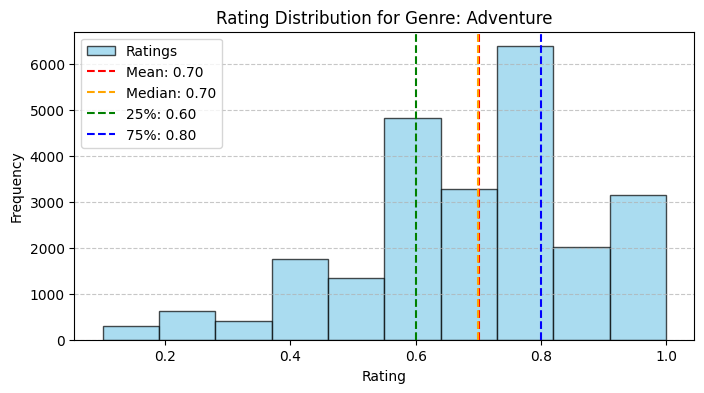

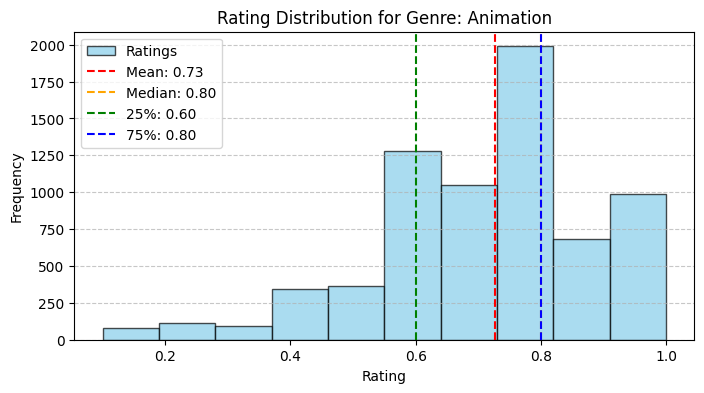

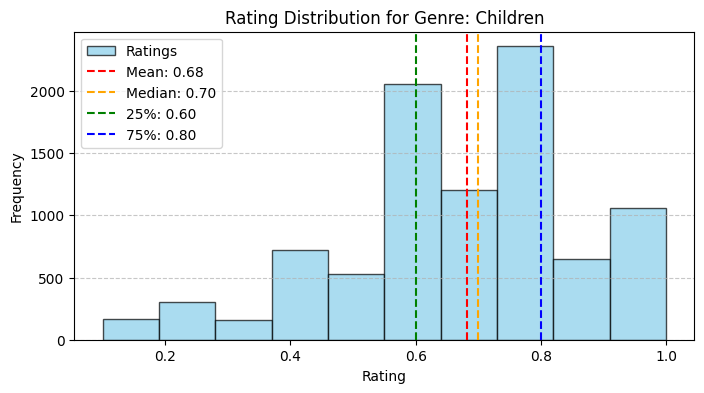

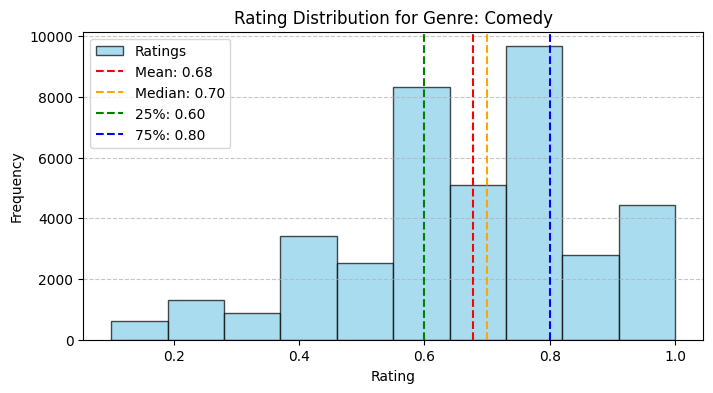

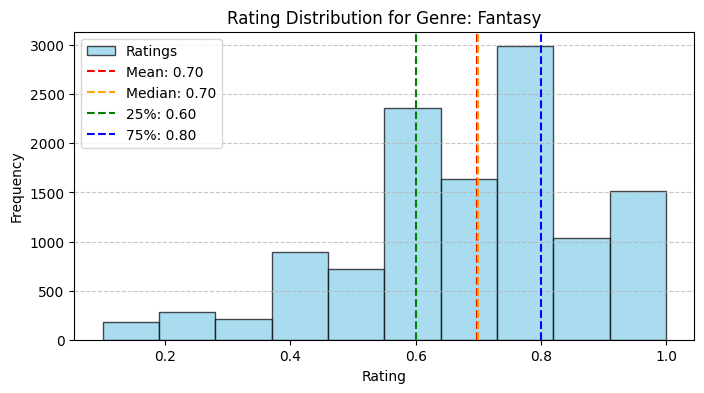

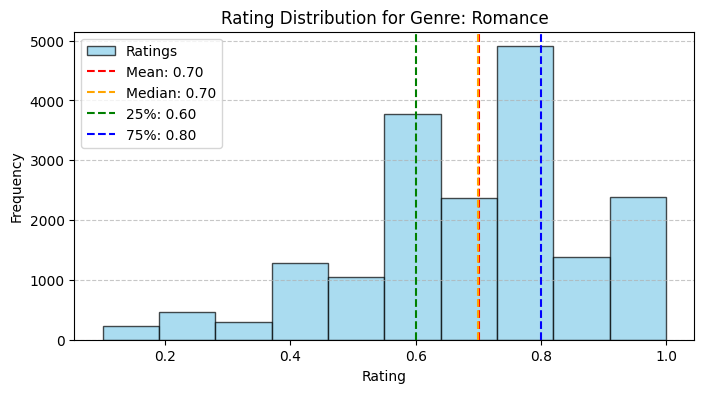

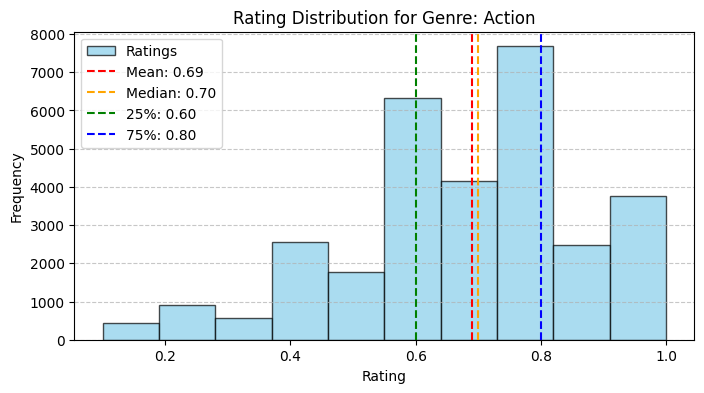

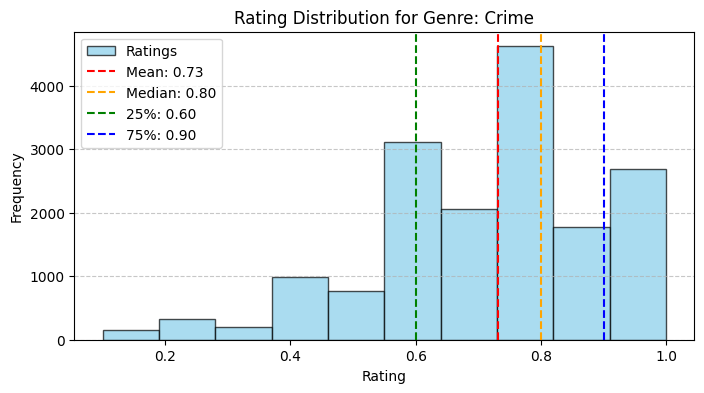

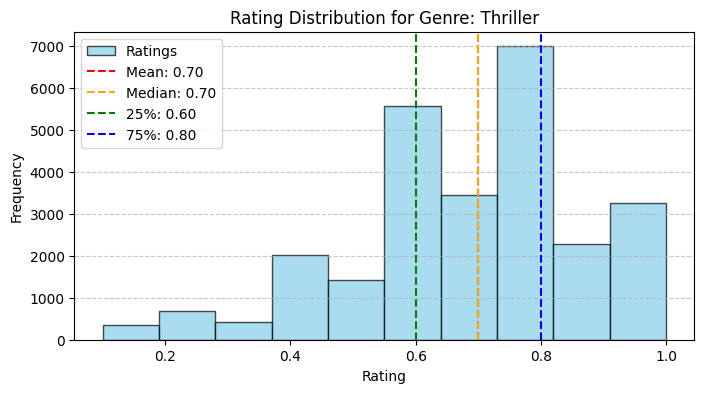

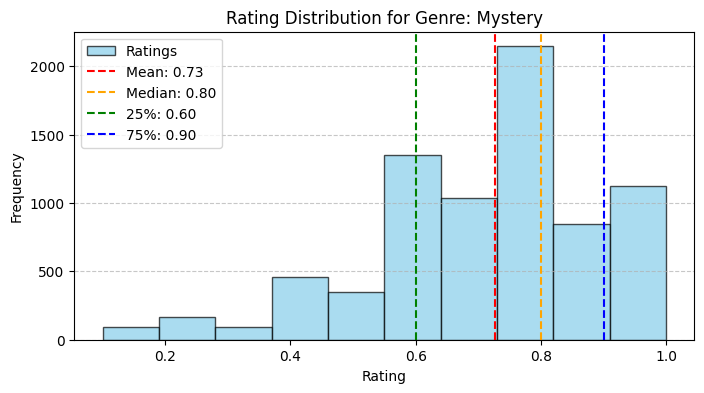

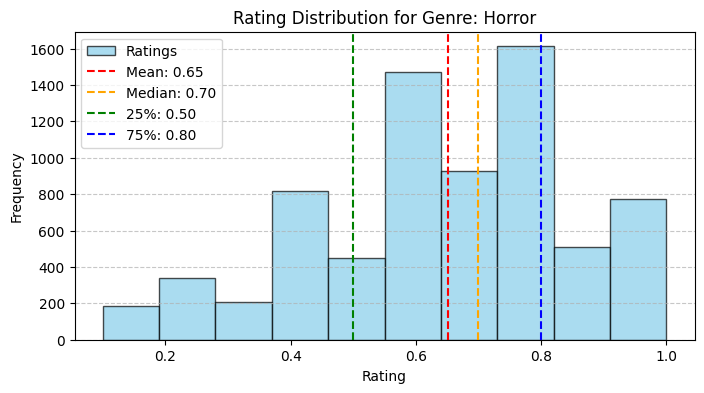

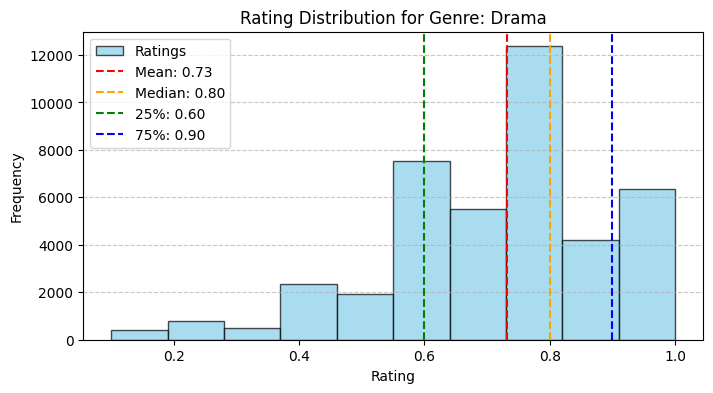

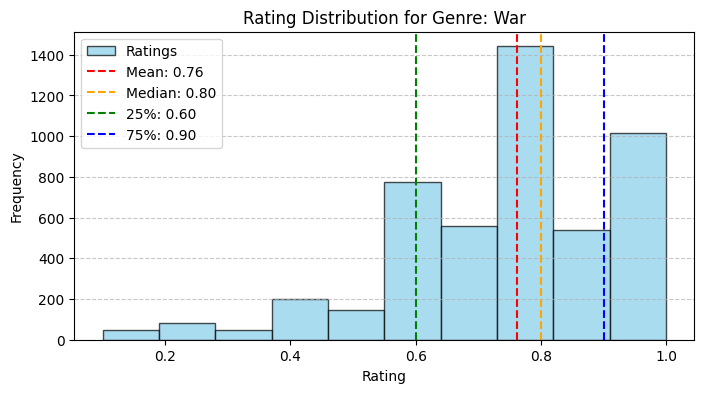

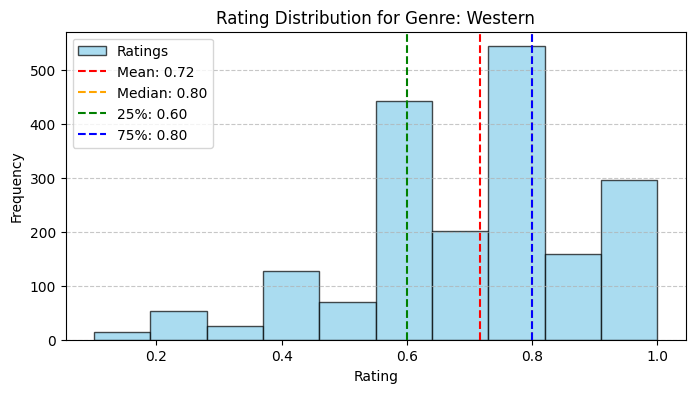

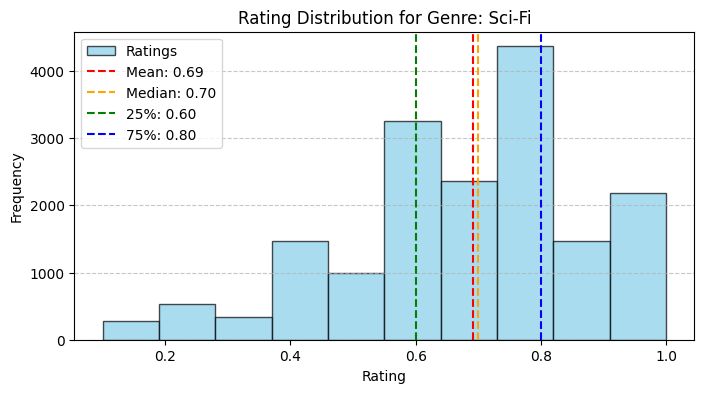

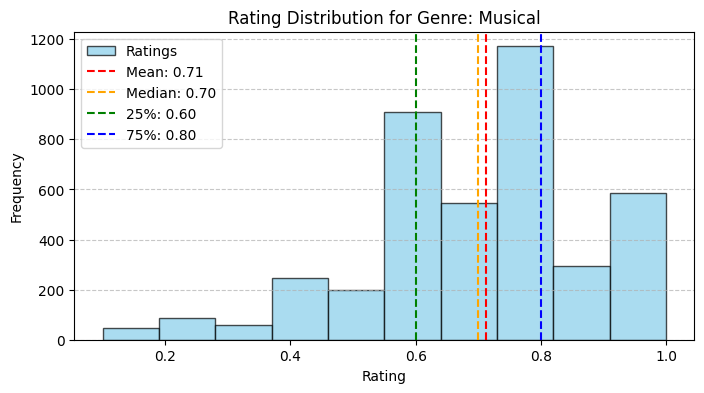

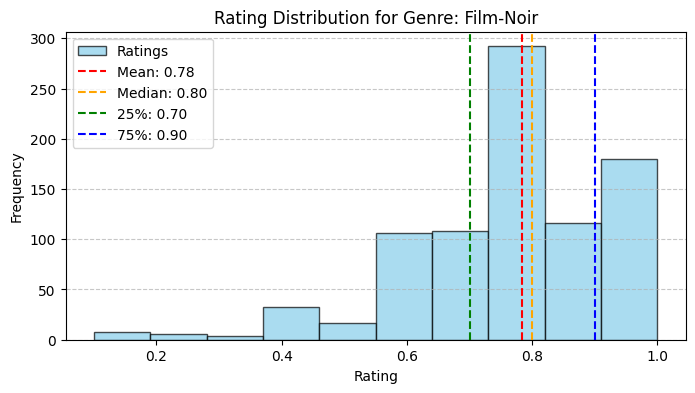

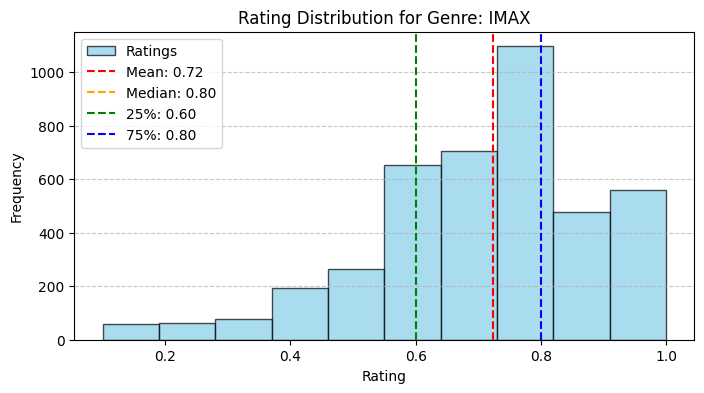

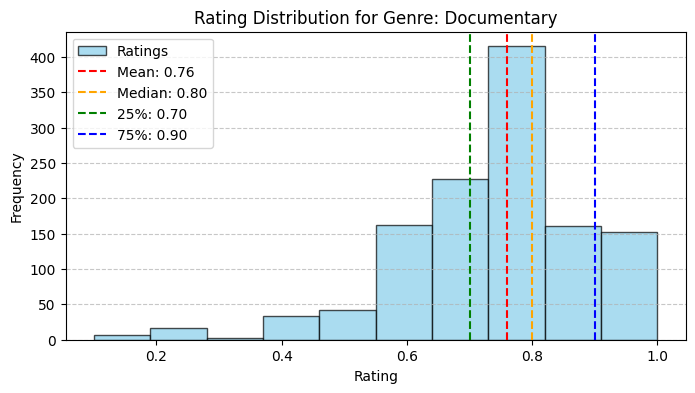

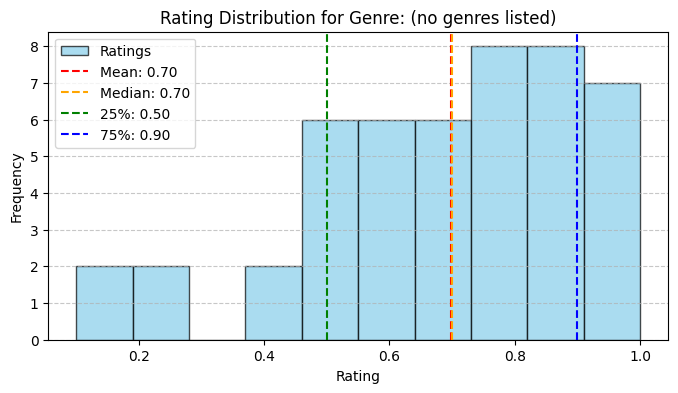

In [97]:
import matplotlib.pyplot as plt

for genre, ratings in genre_ratings.items():
    if len(ratings) > 0 or genre == '(no genre listed)':
        stats_for_genre = genre_stats[genre]
        
        plt.figure(figsize=(8, 4))
        plt.hist(ratings, bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Ratings')
        plt.axvline(stats_for_genre['mean'], color='red', linestyle='--', label=f"Mean: {stats_for_genre['mean']:.2f}")
        plt.axvline(stats_for_genre['median'], color='orange', linestyle='--', label=f"Median: {stats_for_genre['median']:.2f}")
        plt.axvline(stats_for_genre['25%'], color='green', linestyle='--', label=f"25%: {stats_for_genre['25%']:.2f}")
        plt.axvline(stats_for_genre['75%'], color='blue', linestyle='--', label=f"75%: {stats_for_genre['75%']:.2f}")
        
        plt.title(f"Rating Distribution for Genre: {genre}")
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


In [ ]:
user_genre_avg_ratings = {}

for user_id, genres in user_genre_movies.items():
    user_genre_avg_ratings[user_id] = {}
    for genre, movies in genres.items():
        ratings = list([rating for _, (_, rating) in movies.items()])
        if ratings: 
            user_genre_avg_ratings[user_id][genre] = {
                'mean': np.mean(ratings),
                'median': np.median(ratings),
                'count': len(ratings)
            }

for user_id, genre_ratings in list(user_genre_avg_ratings.items())[:3]:
    print(f"User: {user_id}")
    for genre, stats in genre_ratings.items():
        print(f"  Genre: {genre}, Stats: {stats}")

User: 1
  Genre: Adventure, Stats: {'mean': 0.8776470588235293, 'median': 1.0, 'count': 85}
  Genre: Animation, Stats: {'mean': 0.9379310344827586, 'median': 1.0, 'count': 29}
  Genre: Children, Stats: {'mean': 0.9095238095238094, 'median': 1.0, 'count': 42}
  Genre: Comedy, Stats: {'mean': 0.8554216867469879, 'median': 0.8, 'count': 83}
  Genre: Fantasy, Stats: {'mean': 0.8595744680851058, 'median': 0.8, 'count': 47}
  Genre: Romance, Stats: {'mean': 0.8615384615384616, 'median': 0.8, 'count': 26}
  Genre: Action, Stats: {'mean': 0.8644444444444445, 'median': 0.8, 'count': 90}
  Genre: Crime, Stats: {'mean': 0.8711111111111111, 'median': 1.0, 'count': 45}
  Genre: Thriller, Stats: {'mean': 0.829090909090909, 'median': 0.8, 'count': 55}
  Genre: Mystery, Stats: {'mean': 0.8333333333333334, 'median': 1.0, 'count': 18}
  Genre: Horror, Stats: {'mean': 0.6941176470588236, 'median': 0.8, 'count': 17}
  Genre: Drama, Stats: {'mean': 0.9058823529411764, 'median': 1.0, 'count': 68}
  Genre: W

In [ ]:
user_genre_ratings = defaultdict(lambda: defaultdict(list))

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for _, (_, rating) in movies.items():
            user_genre_ratings[user_id][genre].append(rating)

In [ ]:
import statistics

user_genre_bias = {}

for user_id, genres in user_genre_avg_ratings.items():
    genre_means = {genre: stats['mean'] for genre, stats in genres.items() if 'mean' in stats}

    if genre_means:
        max_genre = max(genre_means, key=genre_means.get) 
        min_genre = min(genre_means, key=genre_means.get) 
        
        overall_mean = statistics.mean(genre_means.values())

        max_genre_rating = genre_means[max_genre] 
        min_genre_rating = genre_means[min_genre] 
        
        genre_mean_diffs = {}
        for genre, ratings in user_genre_ratings[user_id].items():
            if len(ratings) > 1: 
                genre_mean_diffs[genre] = max(ratings) - min(ratings)
            else:
                genre_mean_diffs[genre] = 0  

        user_genre_bias[user_id] = {
            'highest_rated_genre': max_genre,
            'highest_rated_genre_rating': max_genre_rating,
            'lowest_rated_genre': min_genre,
            'lowest_rated_genre_rating': min_genre_rating,
            'mean_difference': max_genre_rating - min_genre_rating,
            'average_rating': overall_mean,
            'genre_mean_differences': genre_mean_diffs
        }

for user_id, bias_info in list(user_genre_bias.items())[:3]:
    print(f"User: {user_id}")
    print(f"  Highest Rated Genre: {bias_info['highest_rated_genre']}")
    print(f"  Rating for Highest Genre: {bias_info['highest_rated_genre_rating']:.2f}")
    print(f"  Lowest Rated Genre: {bias_info['lowest_rated_genre']}")
    print(f"  Rating for Lowest Genre: {bias_info['lowest_rated_genre_rating']:.2f}")
    print(f"  Mean Difference: {bias_info['mean_difference']:.2f}")
    print(f"  Average Rating: {bias_info['average_rating']:.2f}")
    print(f"  Genre Mean Differences: {bias_info['genre_mean_differences']}")



User: 1
  Highest Rated Genre: Film-Noir
  Rating for Highest Genre: 1.00
  Lowest Rated Genre: Horror
  Rating for Lowest Genre: 0.69
  Mean Difference: 0.31
  Average Rating: 0.87
  Genre Mean Differences: {'Adventure': 0.6, 'Animation': 0.4, 'Children': 0.4, 'Comedy': 0.6, 'Fantasy': 0.6, 'Romance': 0.4, 'Action': 0.6, 'Crime': 0.6, 'Thriller': 0.8, 'Mystery': 0.8, 'Horror': 0.6, 'Drama': 0.8, 'War': 0.4, 'Western': 0.4, 'Sci-Fi': 0.4, 'Musical': 0.4, 'Film-Noir': 0}
User: 3
  Highest Rated Genre: Mystery
  Rating for Highest Genre: 1.00
  Lowest Rated Genre: War
  Rating for Lowest Genre: 0.10
  Mean Difference: 0.90
  Average Rating: 0.43
  Genre Mean Differences: {'Drama': 0.8, 'War': 0.0, 'Action': 0.9, 'Crime': 0.0, 'Adventure': 0.9, 'Comedy': 0.9, 'Animation': 0.0, 'Sci-Fi': 0.9, 'Thriller': 0.9, 'Musical': 0, 'Romance': 0.0, 'Fantasy': 0.9, 'Children': 0.0, 'Horror': 0.19999999999999996, 'Mystery': 0}
User: 6
  Highest Rated Genre: IMAX
  Rating for Highest Genre: 0.93
  Lowe

In [129]:
from collections import Counter

preferred_genres = Counter(bias['highest_rated_genre'] for bias in user_genre_bias.values())
least_preferred_genres = Counter(bias['lowest_rated_genre'] for bias in user_genre_bias.values())

print("Most Preferred Genres:")
print(preferred_genres.most_common())

print("\nLeast Preferred Genres:")
print(least_preferred_genres.most_common())


Most Preferred Genres:
[('War', 97), ('IMAX', 68), ('Film-Noir', 65), ('Mystery', 60), ('Western', 47), ('Documentary', 44), ('Animation', 39), ('Crime', 35), ('Horror', 35), ('Musical', 29), ('Fantasy', 18), ('Romance', 17), ('Sci-Fi', 15), ('Children', 12), ('Drama', 7), ('(no genres listed)', 7), ('Adventure', 6), ('Action', 4), ('Thriller', 3), ('Comedy', 2)]

Least Preferred Genres:
[('Horror', 104), ('Children', 52), ('Western', 52), ('Fantasy', 45), ('Musical', 44), ('IMAX', 35), ('Sci-Fi', 34), ('Animation', 33), ('War', 32), ('Comedy', 27), ('Romance', 26), ('Mystery', 26), ('Film-Noir', 24), ('Action', 18), ('Crime', 15), ('Adventure', 12), ('Thriller', 11), ('Documentary', 11), ('(no genres listed)', 5), ('Drama', 4)]


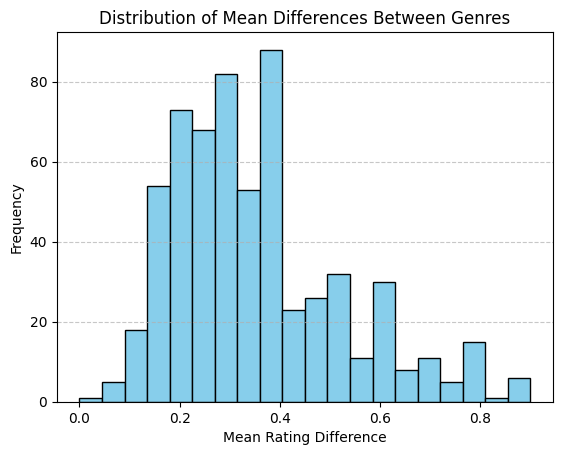

In [131]:
mean_differences = [bias['mean_difference'] for bias in user_genre_bias.values()]

plt.hist(mean_differences, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Mean Differences Between Genres')
plt.xlabel('Mean Rating Difference')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

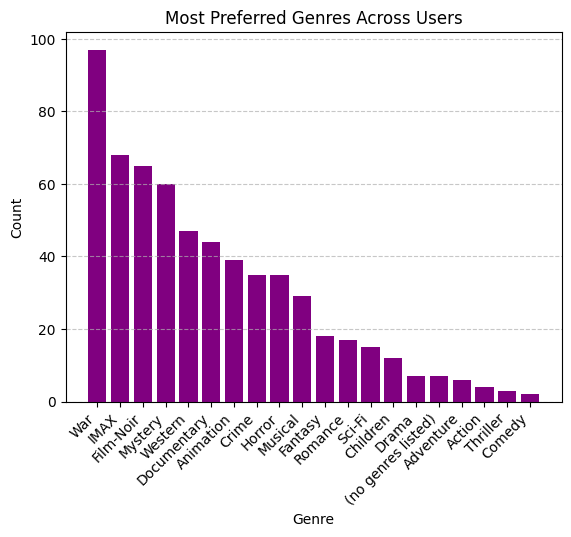

In [132]:
preferred_genres_sorted = preferred_genres.most_common()

genres = [genre for genre, _ in preferred_genres_sorted]
counts = [count for _, count in preferred_genres_sorted]

plt.bar(genres, counts, color='purple')
plt.title('Most Preferred Genres Across Users')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


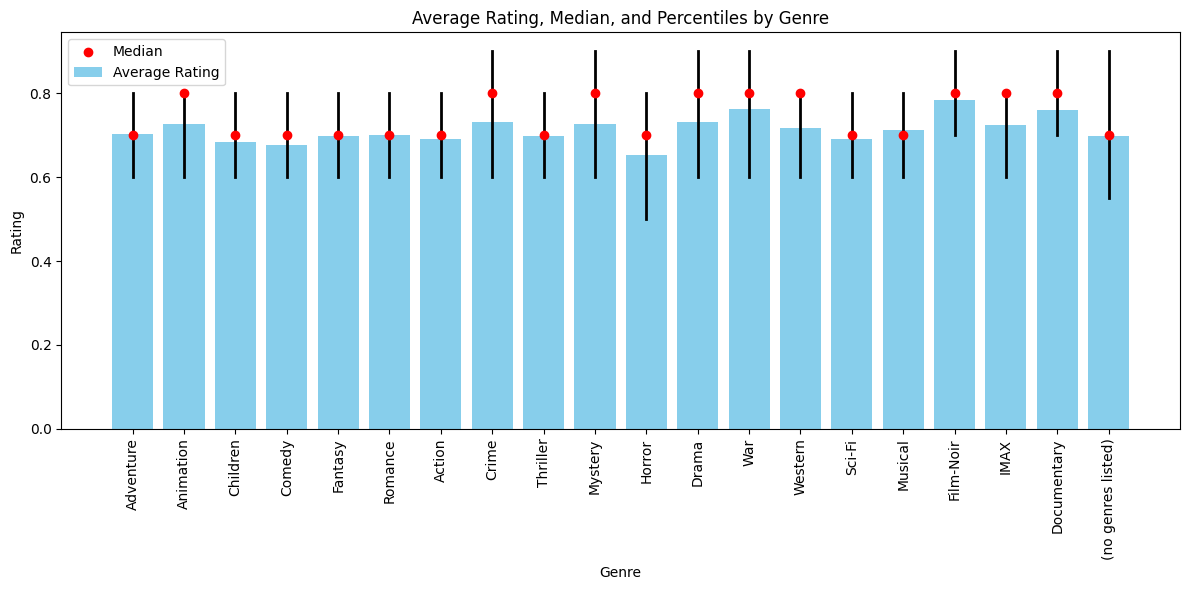

In [134]:
import matplotlib.pyplot as plt
import statistics
import numpy as np
from collections import defaultdict

# Step 1: Calculate the statistics (mean, median, 25%, and 75%) per genre
genre_ratings = defaultdict(list)

# Collect ratings for each genre across all users
for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        ratings = [rating for _, (_, rating) in movies.items()]
        genre_ratings[genre].extend(ratings)

# Step 2: Calculate the statistics for each genre
genre_stats = {}
for genre, ratings in genre_ratings.items():
    if len(ratings) > 0:
        genre_stats[genre] = {
            'mean': statistics.mean(ratings),
            'median': statistics.median(ratings),
            '25%': np.percentile(ratings, 25),
            '75%': np.percentile(ratings, 75)
        }

# Step 3: Prepare data for plotting
genres = list(genre_stats.keys())
means = [genre_stats[genre]['mean'] for genre in genres]
medians = [genre_stats[genre]['median'] for genre in genres]
p25 = [genre_stats[genre]['25%'] for genre in genres]
p75 = [genre_stats[genre]['75%'] for genre in genres]

# Step 4: Plot the statistics for each genre
plt.figure(figsize=(12, 6))

# Plot the average rating as a bar plot
plt.bar(genres, means, color='skyblue', label='Average Rating')

# Overlay lines for median, 25%, and 75% percentiles
for i, genre in enumerate(genres):
    plt.plot([i, i], [p25[i], p75[i]], color='black', linewidth=2)  # Line between 25% and 75%
    plt.scatter([i], [medians[i]], color='red', zorder=5, label='Median' if i == 0 else "")  # Median point

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('Average Rating, Median, and Percentiles by Genre')

# Rotate the genre labels for better readability
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



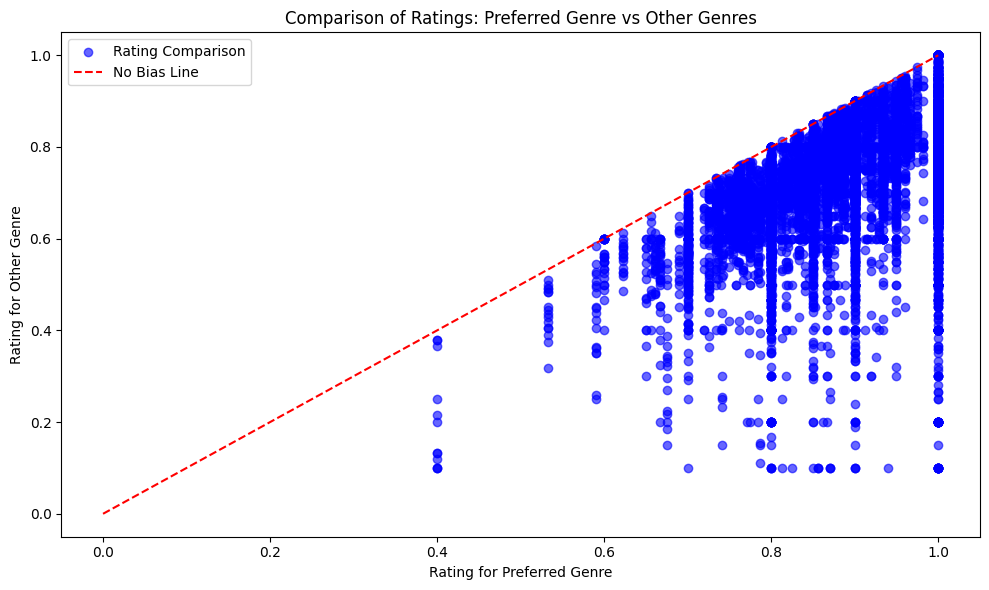

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import statistics

# Step 1: Calculate the average rating for each genre per user
user_genre_avg_ratings = {}

for user_id, genres in user_genre_movies.items():
    user_genre_avg_ratings[user_id] = {}
    for genre, movies in genres.items():
        ratings = [rating for _, (_, rating) in movies.items()]
        if ratings:  # If there are ratings for this genre
            user_genre_avg_ratings[user_id][genre] = statistics.mean(ratings)

# Step 2: Find the preferred genre for each user (highest average rating)
user_bias_data = []

for user_id, genre_avg in user_genre_avg_ratings.items():
    # Find the genre with the highest average rating
    if not genre_avg:
        continue
    preferred_genre = max(genre_avg, key=genre_avg.get)
    preferred_genre_rating = genre_avg[preferred_genre]
    
    # Get the average ratings for all other genres
    other_genres_avg = {genre: rating for genre, rating in genre_avg.items() if genre != preferred_genre}

    # Record the data for plotting (preferred genre rating and other genres' ratings)
    for genre, rating in other_genres_avg.items():
        user_bias_data.append({
            'user_id': user_id,
            'preferred_genre': preferred_genre,
            'preferred_genre_rating': preferred_genre_rating,
            'other_genre': genre,
            'other_genre_rating': rating
        })

# Step 3: Create a plot to show the bias
# Prepare data for the plot
preferred_ratings = [data['preferred_genre_rating'] for data in user_bias_data]
other_ratings = [data['other_genre_rating'] for data in user_bias_data]

# Step 4: Plot the comparison between preferred genre rating and other genres' ratings
plt.figure(figsize=(10, 6))

# Scatter plot: Each point represents a comparison between preferred genre vs other genre for each user
plt.scatter(preferred_ratings, other_ratings, alpha=0.6, color='blue', label='Rating Comparison')

# Plotting a 45-degree line to show where ratings would be equal (no bias)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="No Bias Line")

# Add labels and title
plt.xlabel('Rating for Preferred Genre')
plt.ylabel('Rating for Other Genre')
plt.title('Comparison of Ratings: Preferred Genre vs Other Genres')

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


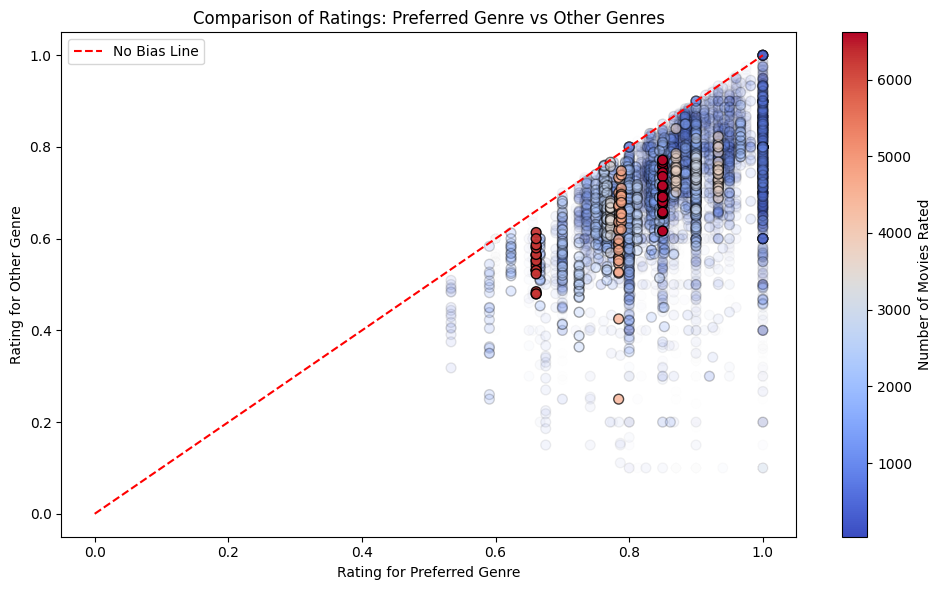

In [150]:
import matplotlib.pyplot as plt
import statistics
import matplotlib.colors as mcolors

# Step 1: Calculate the average rating for each genre per user
user_genre_avg_ratings = {}
user_movie_counts = {}  # To store the number of movies each user has rated

for user_id, genres in user_genre_movies.items():
    user_genre_avg_ratings[user_id] = {}
    user_movie_counts[user_id] = 0  # Initialize the movie count for each user
    
    for genre, movies in genres.items():
        ratings = [rating for _, (_, rating) in movies.items()]
        user_movie_counts[user_id] += len(ratings)  # Count the number of rated movies for this user
        
        if ratings:  # If there are ratings for this genre
            user_genre_avg_ratings[user_id][genre] = statistics.mean(ratings)

# Step 2: Find the preferred genre for each user (highest average rating)
user_bias_data = []

for user_id, genre_avg in user_genre_avg_ratings.items():
    # Find the genre with the highest average rating
    if not genre_avg:
        continue
    preferred_genre = max(genre_avg, key=genre_avg.get)
    preferred_genre_rating = genre_avg[preferred_genre]
    
    # Get the average ratings for all other genres
    other_genres_avg = {genre: rating for genre, rating in genre_avg.items() if genre != preferred_genre}

    # Record the data for plotting (preferred genre rating and other genres' ratings)
    for genre, rating in other_genres_avg.items():
        user_bias_data.append({
            'user_id': user_id,
            'preferred_genre': preferred_genre,
            'preferred_genre_rating': preferred_genre_rating,
            'other_genre': genre,
            'other_genre_rating': rating,
            'num_movies': user_movie_counts[user_id]  # Add the number of movies rated by the user
        })

# Step 3: Create a plot to show the bias with color scale based on the number of ratings
# Prepare data for the plot
preferred_ratings = [data['preferred_genre_rating'] for data in user_bias_data]
other_ratings = [data['other_genre_rating'] for data in user_bias_data]
num_movies = [data['num_movies'] for data in user_bias_data]

# Normalize the number of movies for the color map
norm = mcolors.Normalize(vmin=min(num_movies), vmax=max(num_movies))
cmap = plt.cm.coolwarm  # Using a different color map to highlight extremes

# Step 4: Set transparency based on the number of ratings (higher transparency for more ratings)
alpha_values = [(num_movies[i] - min(num_movies)) / (max(num_movies) - min(num_movies)) for i in range(len(num_movies))]

# Step 5: Sort data points by their alpha values so that higher opacity points come on top
sorted_data = sorted(zip(preferred_ratings, other_ratings, num_movies, alpha_values), key=lambda x: x[3], reverse=False)

# Unzip the sorted data
sorted_preferred_ratings, sorted_other_ratings, sorted_num_movies, sorted_alpha_values = zip(*sorted_data)

# Step 6: Plot the comparison between preferred genre rating and other genres' ratings
plt.figure(figsize=(10, 6))

# Scatter plot: Each point represents a comparison between preferred genre vs other genre for each user
scatter = plt.scatter(sorted_preferred_ratings, sorted_other_ratings, c=sorted_num_movies, cmap=cmap, alpha=sorted_alpha_values, edgecolors='k', s=50, norm=norm)

# Plotting a 45-degree line to show where ratings would be equal (no bias)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="No Bias Line")

# Add labels and title
plt.xlabel('Rating for Preferred Genre')
plt.ylabel('Rating for Other Genre')
plt.title('Comparison of Ratings: Preferred Genre vs Other Genres')

# Add a colorbar with the number of rated movies
cbar = plt.colorbar(scatter, ax=plt.gca())
cbar.set_label('Number of Movies Rated')

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

